In [7]:
from pyscenic.rnkdb import RankingDatabase
from pyscenic.genesig import GeneSignature, Regulome
from pyscenic.recovery import enrichment, leading_edge
import matplotlib.pyplot as plt
from functools import partial
import glob
import os
from dask import delayed
import numpy as np
import pandas as pd

In [8]:
%matplotlib inline

In [23]:
RESOURCES_FOLDER = "/Users/bramvandesande/Projects/lcb/resources/"

Gene signatures are downloaded from MSigDB (http://software.broadinstitute.org/gsea/msigdb). The module C6 is used in this notebook.

In [11]:
GMT_FNAME = "/Users/bramvandesande/Projects/lcb/resources/c6.all.v6.1.symbols.gmt.txt"

In [12]:
msigdb_c6 = GeneSignature.from_gmt(
                        fname=GMT_FNAME,
                        nomenclature="HGNC",
                        gene_separator="\t",
                        field_separator="\t")
len(msigdb_c6)

189

In [13]:
msigdb_c6[0]

GeneSignature(name='GLI1_UP.V1_DN', nomenclature='HGNC', gene2weights=<frozendict {'COPZ1': 1.0, 'C10orf46': 1.0, 'C20orf118': 1.0, 'TMEM181': 1.0, 'CCNL2': 1.0, 'YIPF1': 1.0, 'GTDC1': 1.0, 'OPN3': 1.0, 'RSAD2': 1.0, 'SLC22A1': 1.0, 'LIN37': 1.0, 'RNF10': 1.0, 'RUNX1': 1.0, 'QRICH2': 1.0, 'SEPT9': 1.0, 'ARPC2': 1.0, 'CD2AP': 1.0, 'ACSL6': 1.0, 'ZMYND11': 1.0, 'BBX': 1.0, 'TMEM62': 1.0, 'FOLR1': 1.0, 'TMEM189': 1.0, 'PPIL1': 1.0, 'CYP3A7': 1.0, 'SELM': 1.0, 'ESYT1': 1.0, 'BTBD16': 1.0, 'SPECC1': 1.0}>)

Make connection to a database of whole genome rankings.

In [14]:
DB_GLOB = "/Users/bramvandesande/Projects/lcb/databases/hg19-*.db"

In [15]:
db_fnames = glob.glob(DB_GLOB)
db_fnames

['/Users/bramvandesande/Projects/lcb/databases/hg19-tss-centered-5kb-10species.mc9nr.db',
 '/Users/bramvandesande/Projects/lcb/databases/hg19-500bp-upstream-10species.mc9nr.db',
 '/Users/bramvandesande/Projects/lcb/databases/hg19-tss-centered-10kb-7species.mc9nr.db',
 '/Users/bramvandesande/Projects/lcb/databases/hg19-500bp-upstream-7species.mc9nr.db',
 '/Users/bramvandesande/Projects/lcb/databases/hg19-tss-centered-5kb-7species.mc9nr.db',
 '/Users/bramvandesande/Projects/lcb/databases/hg19-tss-centered-10kb-10species.mc9nr.db']

In [16]:
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname), nomenclature="HGNC") for fname in db_fnames]

In [17]:
dbs

[RankingDatabase(name="hg19-tss-centered-5kb-10species",n_features=24453),
 RankingDatabase(name="hg19-500bp-upstream-10species",n_features=24453),
 RankingDatabase(name="hg19-tss-centered-10kb-7species",n_features=24453),
 RankingDatabase(name="hg19-500bp-upstream-7species",n_features=24453),
 RankingDatabase(name="hg19-tss-centered-5kb-7species",n_features=24453),
 RankingDatabase(name="hg19-tss-centered-10kb-10species",n_features=24453)]

Look for enrichment of a gene signature.

In [18]:
df = enrichment(dbs[0], msigdb_c6[0]).sort_values(by=('Enrichment', 'NES'), ascending=False)
df[('Metadata', 'Signature')] = msigdb_c6[0].name
df[('Metadata', 'Database')] = dbs[0].name

In [19]:
df.head()

Enrichment            \
                                                          AUC       NES   
predrem__nrMotif81                                   0.000223  5.126996   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...   0.000212  4.789967   
cisbp__M3230                                         0.000208  4.673257   
hocomoco__ZIM3_HUMAN.H11MO.0.C                       0.000203  4.516057   
transfac_pro__M06436                                 0.000202  4.502957   

                                                   Recovery                 \
                                                          0    1    2    3   
predrem__nrMotif81                                      0.0  0.0  0.0  0.0   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...      0.0  0.0  0.0  0.0   
cisbp__M3230                                            0.0  0.0  0.0  0.0   
hocomoco__ZIM3_HUMAN.H11MO.0.C                          0.0  0.0  0.0  0.0   
transfac_pro__M06436                                    0.0  0.0  0.0  0.0   

                                                                        \
                                                      4    5    6    7   
predrem__nrMotif81                                  0.0  0.0  0.0  0.0   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...  0.0  0.0  0.0  0.0   
cisbp__M3230                                        0.0  0.0  0.0  0.0   
hocomoco__ZIM3_HUMAN.H11MO.0.C                      0.0  0.0  0.0  0.0   
transfac_pro__M06436                                0.0  0.0  0.0  0.0   

                                                                 ...                 \
                                                                 ...                  
predrem__nrMotif81                                               ...                  
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...               ...                  
cisbp__M3230                                                     ...                  
hocomoco__ZIM3_HUMAN.H11MO.0.C                                   ...                  
transfac_pro__M06436                                             ...                  

                                                   Ranking                 \
                                                     SEPT9 SLC22A1 SPECC1   
predrem__nrMotif81                                     167   13245   8538   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...     198   11066  12243   
cisbp__M3230                                            43    2423   2552   
hocomoco__ZIM3_HUMAN.H11MO.0.C                        2496    6671   3171   
transfac_pro__M06436                                   120   17079   6585   

                                                                           \
                                                   TMEM181 TMEM189 TMEM62   
predrem__nrMotif81                                     111   13463     85   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...    4486     990    250   
cisbp__M3230                                         13525   18634    773   
hocomoco__ZIM3_HUMAN.H11MO.0.C                        9306   13108    330   
transfac_pro__M06436                                 19020   12863   4175   

                                                                  \
                                                   YIPF1 ZMYND11   
predrem__nrMotif81                                  2483     719   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...   154    4134   
cisbp__M3230                                         350    4661   
hocomoco__ZIM3_HUMAN.H11MO.0.C                      3078   12106   
transfac_pro__M06436                                3315    7253   

                                                         Metadata  \
                                                        Signature   
predrem__nrMotif81                                  GLI1_UP.V1_DN   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...  GLI1_UP.V1_DN   
cisbp__M3230    

In [34]:
motif2tf = pd.read_csv(os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl"),
                      sep='\t', index_col=0)

/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
from itertools import repeat
COLUMN_NAMES = ['gene_name', 'motif_similarity_qvalue', 'orthologous_identity', 'description']
motif2tf = motif2tf[COLUMN_NAMES]
motif2tf.columns = list(zip(repeat('Motif2TF'), COLUMN_NAMES))

In [45]:
motif2tf.head()

,"(Motif2TF, gene_name)","(Motif2TF, motif_similarity_qvalue)","(Motif2TF, orthologous_identity)","(Motif2TF, description)"
#motif_id,,,,
bergman__Abd-B,Hoxa9,0.0006,1.000000,gene is annotated for similar motif cisbp__M10...
bergman__Aef1,Zfp128,0.0000,0.220264,motif is annotated for orthologous gene FBgn00...
bergman__Cf2,Zfp853,0.0000,0.166667,motif is annotated for orthologous gene FBgn00...
bergman__EcR_usp,Nr1h2,0.0000,0.378924,gene is orthologous to FBgn0000546 in D. melan...
bergman__EcR_usp,Nr1h3,0.0000,0.408989,gene is orthologous to FBgn0000546 in D. melan...


In [35]:
motif2TF

,motif_name,motif_description,source_name,source_version,gene_name,motif_similarity_qvalue,similar_motif_id,similar_motif_description,orthologous_identity,orthologous_gene_name,orthologous_species,description
#motif_id,,,,,,,,,,,,
bergman__Abd-B,Abd-B,Abd-B,bergman,1.1,HOXA9,0.000600,cisbp__M1008,"HOXA6[gene ID: ""ENSG00000106006"" species: ""Hom...",0.981618,ENSMUSG00000038227,M. musculus,gene is orthologous to ENSMUSG00000038227 in M...
bergman__Aef1,Aef1,Aef1,bergman,1.1,ZNF8,0.000000,None,None,0.213656,FBgn0005694,D. melanogaster,motif is annotated for orthologous gene FBgn00...
bergman__Cf2,Cf2,Cf2,bergman,1.1,ZNF853,0.000000,None,None,0.150980,FBgn0000286,D. melanogaster,motif is annotated for orthologous gene FBgn00...
bergman__EcR_usp,EcR_usp,EcR/usp,bergman,1.1,NR1H2,0.000000,None,None,0.378261,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...
bergman__EcR_usp,EcR_usp,EcR/usp,bergman,1.1,NR1H3,0.000000,None,None,0.406181,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...
bergman__EcR_usp,EcR_usp,EcR/usp,bergman,1.1,NR1H4,0.000000,None,None,0.302469,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...
bergman__EcR_usp,EcR_usp,EcR/usp,bergman,1.1,NR1I2,0.000000,None,None,0.213531,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...
bergman__EcR_usp,EcR_usp,EcR/usp,bergman,1.1,NR1I3,0.000000,None,None,0.282913,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...
bergman__EcR_usp,EcR_usp,EcR/usp,bergman,1.1,NR2F1,0.000002,taipale_cyt_meth__NR2F1_NRGGTCRNTGACCYN_FL,NR2F1 [Nuclear_receptor],1.000000,None,None,gene is annotated for similar motif taipale_cy...


In [47]:
pd.merge(df, motif2tf, how='left', left_index=True, right_index=True).head(10)

/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


Enrichment           Recovery                                \
                        AUC       NES        0    1    2    3    4    5    6   
bergman__Abd-B     0.000086  1.065976      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__Adf1      0.000067  0.509819      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__Aef1      0.000073  0.687266      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__Cf2       0.000100  1.468506      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__Dip3      0.000047 -0.097547      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__Dref      0.000113  1.867462      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__EcR_usp   0.000010 -1.178898      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__EcR_usp   0.000010 -1.178898      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__EcR_usp   0.000010 -1.178898      0.0  0.0  0.0  0.0  0.0  0.0  0.0   
bergman__EcR_usp   0.000010 -1.178898      0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                             ...                          \
                    7                        ...                           
bergman__Abd-B    0.0                        ...                           
bergman__Adf1     0.0                        ...                           
bergman__Aef1     0.0                        ...                           
bergman__Cf2      0.0                        ...                           
bergman__Dip3     0.0                        ...                           
bergman__Dref     0.0                        ...                           
bergman__EcR_usp  0.0                        ...                           
bergman__EcR_usp  0.0                        ...                           
bergman__EcR_usp  0.0                        ...                           
bergman__EcR_usp  0.0                        ...                           

                 Ranking                            Metadata  \
                 TMEM189 TMEM62 YIPF1 ZMYND11      Signature   
bergman__Abd-B     16462    449  1760    6698  GLI1_UP.V1_DN   
bergman__Adf1      12918    470  7839    7617  GLI1_UP.V1_DN   
bergman__Aef1      17116     18   409    7362  GLI1_UP.V1_DN   
bergman__Cf2       11958    141  3790     432  GLI1_UP.V1_DN   
bergman__Dip3       2978   2346  6373   11790  GLI1_UP.V1_DN   
bergman__Dref      16929    583   436    4220  GLI1_UP.V1_DN   
bergman__EcR_usp    8694    863  3581   12205  GLI1_UP.V1_DN   
bergman__EcR_usp    8694    863  3581   12205  GLI1_UP.V1_DN   
bergman__EcR_usp    8694    863  3581   12205  GLI1_UP.V1_DN   
bergman__EcR_usp    8694    863  3581   12205  GLI1_UP.V1_DN   

                                                   Motif2TF  \
                                         Database gene_name   
bergman__Abd-B    hg19-tss-centered-5kb-10species     Hoxa9   
bergman__Adf1     hg19-tss-centered-5kb-10species       NaN   
bergman__Aef1     hg19-tss-centered-5kb-10species    Zfp128   
bergman__Cf2      hg19-tss-centered-5kb-10species    Zfp853   
bergman__Dip3     hg19-tss-centered-5kb-10species       NaN   
bergman__Dref     hg19-tss-centered-5kb-10species       NaN   
bergman__EcR_usp  hg19-tss-centered-5kb-10species     Nr1h2   
bergman__EcR_usp  hg19-tss-centered-5kb-10species     Nr1h3   
bergman__EcR_usp  hg19-tss-centered-5kb-10species     Nr1h4   
bergman__EcR_usp  hg19-tss-centered-5kb-10species     Nr1h5   

                                                               \
                 motif_similarity_qvalue orthologous_identity   
bergman__Abd-B                    0.0006             1.000000   
bergman__Adf1                        NaN                  NaN   
bergman__Aef1                     0.0000             0.220264   
bergman__Cf2                      0.0000             0.166667   
bergman__Dip3                        NaN                  NaN   
bergman__Dref                        NaN                  NaN   
bergman__EcR_usp                  0.0000             0.378924   
bergman__EcR_usp                

In [11]:
%load_ext snakeviz

In [12]:
%%snakeviz
df = enrichment(dbs[0], msigdb_c6[0]).sort_values(by=('Enrichment', 'NES'), ascending=False)
df[('Metadata', 'Signature')] = msigdb_c6[0].name
df[('Metadata', 'Database')] = dbs[0].name

 
*** Profile stats marshalled to file '/var/folders/4t/k7tnrw0s29393swkpr9shwjsf4vt0f/T/tmpf8k1la2p'. 


FileNotFoundError: [Errno 2] No such file or directory: 'snakeviz': 'snakeviz'

In [11]:
len(df)

24453

In [12]:
df.head()

Enrichment            \
                                                          AUC       NES   
predrem__nrMotif81                                   0.000223  5.126996   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...   0.000212  4.789967   
cisbp__M3230                                         0.000208  4.673257   
hocomoco__ZIM3_HUMAN.H11MO.0.C                       0.000203  4.516057   
transfac_pro__M06436                                 0.000202  4.502957   

                                                   Recovery                 \
                                                          0    1    2    3   
predrem__nrMotif81                                      0.0  0.0  0.0  0.0   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...      0.0  0.0  0.0  0.0   
cisbp__M3230                                            0.0  0.0  0.0  0.0   
hocomoco__ZIM3_HUMAN.H11MO.0.C                          0.0  0.0  0.0  0.0   
transfac_pro__M06436                                    0.0  0.0  0.0  0.0   

                                                                        \
                                                      4    5    6    7   
predrem__nrMotif81                                  0.0  0.0  0.0  0.0   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...  0.0  0.0  0.0  0.0   
cisbp__M3230                                        0.0  0.0  0.0  0.0   
hocomoco__ZIM3_HUMAN.H11MO.0.C                      0.0  0.0  0.0  0.0   
transfac_pro__M06436                                0.0  0.0  0.0  0.0   

                                                                 ...                 \
                                                                 ...                  
predrem__nrMotif81                                               ...                  
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...               ...                  
cisbp__M3230                                                     ...                  
hocomoco__ZIM3_HUMAN.H11MO.0.C                                   ...                  
transfac_pro__M06436                                             ...                  

                                                   Ranking                 \
                                                     SEPT9 SLC22A1 SPECC1   
predrem__nrMotif81                                     167   13245   8538   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...     198   11066  12243   
cisbp__M3230                                            43    2423   2552   
hocomoco__ZIM3_HUMAN.H11MO.0.C                        2496    6671   3171   
transfac_pro__M06436                                   120   17079   6585   

                                                                           \
                                                   TMEM181 TMEM189 TMEM62   
predrem__nrMotif81                                     111   13463     85   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...    4486     990    250   
cisbp__M3230                                         13525   18634    773   
hocomoco__ZIM3_HUMAN.H11MO.0.C                        9306   13108    330   
transfac_pro__M06436                                 19020   12863   4175   

                                                                  \
                                                   YIPF1 ZMYND11   
predrem__nrMotif81                                  2483     719   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...   154    4134   
cisbp__M3230                                         350    4661   
hocomoco__ZIM3_HUMAN.H11MO.0.C                      3078   12106   
transfac_pro__M06436                                3315    7253   

                                                         Metadata  \
                                                        Signature   
predrem__nrMotif81                                  GLI1_UP.V1_DN   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...  GLI1_UP.V1_DN   
cisbp__M3230    

In [13]:
def auc_histogram(df, nes_threshold=2.5, n_bins=100, normalize=True):
    aucs = df[('Enrichment', 'AUC')].values
    
    bin_edges = np.linspace(start=aucs.min(), stop=aucs.max(), num=n_bins + 1, endpoint=True)
    bin_width = bin_edges[1] - bin_edges[0]
    ns, _ = np.histogram(aucs, bins=bin_edges)
    histogram = ns / np.float_(len(aucs)) if normalize else ns
    max_n = histogram.max()

    from matplotlib.ticker import FormatStrFormatter
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1E'))
    
    p = plt.bar(bin_edges[:-1], histogram, color='g', width=bin_width, alpha=0.5)
    auc_threshold = (nes_threshold * aucs.std()) + aucs.mean()
    plt.plot([auc_threshold, auc_threshold], [0, max_n], color='k', linestyle=':')    
    
    plt.xlabel('AUC')
    plt.ylabel('p' if normalize else 'N')
    plt.xticks(rotation=45)
    plt.xlim(bin_edges[[0, -1]])
    plt.ylim([0, max_n])    

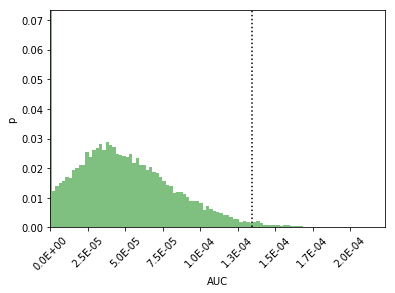

In [14]:
auc_histogram(df)

In [15]:
len(df[df[('Enrichment', 'NES')] >= 2.5])

386

In [16]:
avgrcc = df['Recovery'].mean(axis=0)
stdrcc = df['Recovery'].std(axis=0)
avg2stdrcc = avgrcc + 2.0 * stdrcc

In [17]:
df[('Enrichment', 'LE')] = df[df[('Enrichment', 'NES')] >= 2.5][['Recovery', 'Ranking']].apply(
    partial(leading_edge, avg2stdrcc=avg2stdrcc, genes=df['Ranking'].columns.values, nomenclature="HGNC"),
    axis=1)

In [18]:
df.head()

Enrichment            \
                                                          AUC       NES   
predrem__nrMotif81                                   0.000223  5.126996   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...   0.000212  4.789967   
cisbp__M3230                                         0.000208  4.673257   
hocomoco__ZIM3_HUMAN.H11MO.0.C                       0.000203  4.516057   
transfac_pro__M06436                                 0.000202  4.502957   

                                                   Recovery                 \
                                                          0    1    2    3   
predrem__nrMotif81                                      0.0  0.0  0.0  0.0   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...      0.0  0.0  0.0  0.0   
cisbp__M3230                                            0.0  0.0  0.0  0.0   
hocomoco__ZIM3_HUMAN.H11MO.0.C                          0.0  0.0  0.0  0.0   
transfac_pro__M06436                                    0.0  0.0  0.0  0.0   

                                                                        \
                                                      4    5    6    7   
predrem__nrMotif81                                  0.0  0.0  0.0  0.0   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...  0.0  0.0  0.0  0.0   
cisbp__M3230                                        0.0  0.0  0.0  0.0   
hocomoco__ZIM3_HUMAN.H11MO.0.C                      0.0  0.0  0.0  0.0   
transfac_pro__M06436                                0.0  0.0  0.0  0.0   

                                                                          ...                          \
                                                                          ...                           
predrem__nrMotif81                                                        ...                           
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...                        ...                           
cisbp__M3230                                                              ...                           
hocomoco__ZIM3_HUMAN.H11MO.0.C                                            ...                           
transfac_pro__M06436                                                      ...                           

                                                   Ranking                 \
                                                   SLC22A1 SPECC1 TMEM181   
predrem__nrMotif81                                   13245   8538     111   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...   11066  12243    4486   
cisbp__M3230                                          2423   2552   13525   
hocomoco__ZIM3_HUMAN.H11MO.0.C                        6671   3171    9306   
transfac_pro__M06436                                 17079   6585   19020   

                                                                         \
                                                   TMEM189 TMEM62 YIPF1   
predrem__nrMotif81                                   13463     85  2483   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...     990    250   154   
cisbp__M3230                                         18634    773   350   
hocomoco__ZIM3_HUMAN.H11MO.0.C                       13108    330  3078   
transfac_pro__M06436                                 12863   4175  3315   

                                                                 Metadata  \
                                                   ZMYND11      Signature   
predrem__nrMotif81                                     719  GLI1_UP.V1_DN   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...    4134  GLI1_UP.V1_DN   
cisbp__M3230                                          4661  GLI1_UP.V1_DN   
hocomoco__ZIM3_HUMAN.H11MO.0.C                       12106  GLI1_UP.V1_DN   
transfac_pro__M06436                                  7253  GLI1_UP.V1_DN   

                                                                                     \
                              

Create parallelized version

In [28]:
@delayed
def combine(db, gs):
    df = enrichment(db, gs, rank_threshold=1500).sort_values(by=('Enrichment', 'NES'), ascending=False)
    df[('Metadata', 'Signature')] = gs.name
    df[('Metadata', 'Database')] = db.name
    # TODO: Add TF as metadata if available (i.e. if GeneSignature is a Regulome). In this
    # case we should not yet speak about regulomes but "co-expression" modules.
    # Data to keep here is AUC distribution
    return df[df[('Enrichment', 'NES')] >= 2.5]
    
@delayed
def add_le(df):
    avgrcc = df['Recovery'].mean(axis=0)
    stdrcc = df['Recovery'].std(axis=0)
    avg2stdrcc = avgrcc + 2.0 * stdrcc
    # Data to keep here avg2stdrcc and avgrcc!
    df[('Enrichment', 'LE')] = df[['Recovery', 'Ranking']].apply(
                        partial(leading_edge,
                                avg2stdrcc=avg2stdrcc,
                                genes=df['Ranking'].columns.values,
                                nomenclature="HGNC"),
                        axis=1)
    del df['Ranking']
    return df
    
@delayed
def add_tf(df):
    # add columns from motif2TF
    # filter on combinations of the proper TFs
    # create regulomes.
    return df

@delayed
def concat(dfs):
    return pd.concat(dfs)

tasks1 = [combine(db, gs) for db in dbs[0:2] for gs in msigdb_c6[0:2]]
tasks2 = [add_le(task) for task in tasks1]
res = concat(tasks2)

# Add motif2TF data and extract final regulomes!

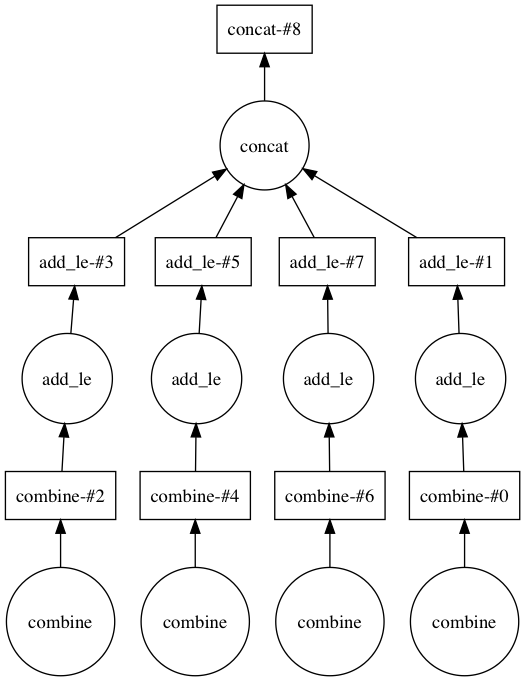

In [29]:
from dask.dot import dot_graph
dot_graph(res.dask)

In [30]:
from dask.multiprocessing import get
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    result = res.compute(get=get, num_workers=4)

In [31]:
from bokeh.io import output_notebook, push_notebook, show
output_notebook()
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Loading BokehJS ...

Column(id='12929776-2494-48c5-9ca0-25e73eb7cb1a', ...)

In [32]:
len(result)

1634

In [34]:
result

Enrichment            \
                                                          AUC       NES   
predrem__nrMotif81                                   0.000223  5.126996   
taipale_tf_pairs__E2F3_FOXI1_NNMCACCGCGCCCMN_CA...   0.000212  4.789967   
cisbp__M3230                                         0.000208  4.673257   
hocomoco__ZIM3_HUMAN.H11MO.0.C                       0.000203  4.516057   
transfac_pro__M06436                                 0.000202  4.502957   
transfac_public__M00011                              0.000200  4.442220   
dbcorrdb__ZNF384__ENCSR000DYP_1__m1                  0.000200  4.429120   
dbcorrdb__SMARCA4__ENCSR000EZC_1__m9                 0.000199  4.391011   
homer__GTCATGCHTGRCTGS_Pax8                          0.000198  4.388629   
flyfactorsurvey__kenF1-CG4360_F2-3_SOLEXA_5          0.000194  4.248101   
cisbp__M0453                                         0.000193  4.217137   
transfac_pro__M06763                                 0.000192  4.189746   
transfac_pro__M05965                                 0.000189  4.108764   
elemento__TACGAGGA                                   0.000187  4.055173   
neph__UW.Motif.0051                                  0.000187  4.050409   
transfac_pro__M09021                                 0.000187  4.038500   
taipale_cyt_meth__ZNF821_NRGACRGACRGACRN_FL_met...   0.000187  4.037309   
neph__UW.Motif.0386                                  0.000186  4.032545   
transfac_pro__M06807                                 0.000185  4.005154   
cisbp__M0547                                         0.000185  3.996818   
tfdimers__MD00191                                    0.000184  3.949181   
transfac_pro__M06455                                 0.000183  3.946799   
tfdimers__MD00421                                    0.000183  3.940845   
predrem__nrMotif759                                  0.000182  3.907499   
tiffin__TIFDMEM0000035                               0.000182  3.888445   
cisbp__M6327                                         0.000181  3.877726   
tfdimers__MD00500                                    0.000180  3.851526   
yetfasco__TBP-TFIIB_1329                             0.000179  3.816990   
taipale_cyt_meth__ZNF821_NRGACRGACRGACRN_FL          0.000179  3.805081   
transfac_pro__M00742                                 0.000178  3.788408   
...                                                       ...       ...   
taipale__CREB3L1_full_NTGCCACGTCANCA                 0.000134  2.559872   
cisbp__M4514                                         0.000134  2.558696   
cisbp__M1243                                         0.000133  2.557519   
cisbp__M6459                                         0.000133  2.556343   
taipale_cyt_meth__ZNF12_GGKSMTRYTTGTTWYAGCANN_e...   0.000133  2.553989   
transfac_pro__M07941                                 0.000133  2.553989   
cisbp__M0345                                         0.000133  2.552813   
neph__UW.Motif.0319                                  0.000133  2.552813   
dbcorrdb__SIX5__ENCSR000BRL_1__m2                    0.000133  2.550460   
taipale_cyt_meth__TEAD1_NRCATWCCN_FL                 0.000133  2.549283   
swissregulon__hs__AIRE.p2                            0.000133  2.549283   
transfac_pro__M03850                                 0.000133  2.548107   
cisbp__M4578                                         0.000133  2.546930   
stark__WHWWWWWWWWKK                                  0.000133  2.546930   
dbcorrdb__USF1__ENCSR000BGI_1__m1                    0.000133  2.546930   
transfac_pro__M06950                                 0.000133  2.544577   
cisbp__M1233                                         0.000133  2.535165   
swissregulon__hs__RFX1..5_RFXANK_RFXAP.p2            0.000133  2.531635   
flyfactorsurvey__Aef1_FlyReg_FBgn0005694             0.000133  2.530459   
transfac_pro__M07708                                 0.000132  2.525753   
dbcorrdb__POLR2A__ENCSR000BGD_1__m1                  0.000132  2.521047   
h

In [35]:
result.to_excel("results.xlsx")